In [1]:
import pandas as pd;pd.set_option('display.max_column',300)
import numpy as np
import seaborn as sns
import pylab as plt
%matplotlib inline
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
import re
from keras.models import Sequential
from keras.layers import LSTM,Dropout,Dense,Embedding,Flatten,Bidirectional

/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _

In [2]:
MAX_FEATURE = 1000

In [3]:
train = pd.read_csv('jigsaw-unintended-bias-in-toxicity-classification/train.csv',nrows=500)
test = pd.read_csv('jigsaw-unintended-bias-in-toxicity-classification/test.csv',nrows=200)

In [4]:
train.head(5)

,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,bisexual,black,buddhist,christian,female,heterosexual,hindu,homosexual_gay_or_lesbian,intellectual_or_learning_disability,jewish,latino,male,muslim,other_disability,other_gender,other_race_or_ethnicity,other_religion,other_sexual_orientation,physical_disability,psychiatric_or_mental_illness,transgender,white,created_date,publication_id,parent_id,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
0,59848,0.000000,"This is so cool. It's like, 'would you want yo...",0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:41.987077+00,2,NaN,2006,rejected,0,0,0,0,0,0.0,0,4
1,59849,0.000000,Thank you!! This would make my life a lot less...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:42.870083+00,2,NaN,2006,rejected,0,0,0,0,0,0.0,0,4
2,59852,0.000000,This is such an urgent design problem; kudos t...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:45.222647+00,2,NaN,2006,rejected,0,0,0,0,0,0.0,0,4
3,59855,0.000000,Is this something I'll be able to install on m...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:47.601894+00,2,NaN,2006,rejected,0,0,0,0,0,0.0,0,4
4,59856,0.893617,haha you guys are a bunch of losers.,0.021277,0.0,0.021277,0.87234,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2015-09-29 10:50:48.488476+00,2,NaN,2006,rejected,0,0,0,1,0,0.0,4,47


In [5]:
train.loc[train['target']>=0.5,'target'] = 1
train.loc[train['target']<0.5,'target'] = 0

In [6]:
train.isnull().sum()/len(train)

id                                     0.000
target                                 0.000
comment_text                           0.000
severe_toxicity                        0.000
obscene                                0.000
identity_attack                        0.000
insult                                 0.000
threat                                 0.000
asian                                  0.862
atheist                                0.862
bisexual                               0.862
black                                  0.862
buddhist                               0.862
christian                              0.862
female                                 0.862
heterosexual                           0.862
hindu                                  0.862
homosexual_gay_or_lesbian              0.862
intellectual_or_learning_disability    0.862
jewish                                 0.862
latino                                 0.862
male                                   0.862
muslim    

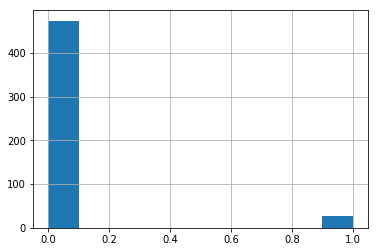

In [7]:
train['target'].hist()

In [8]:
list_all = list(train['comment_text'])+list(test['comment_text'])
from tqdm import tqdm
length_list = []
word_all = []
for i in tqdm(list_all):
    length_list.append(len(i))
    for j in i.split():
        word_all.append(j)
set_all = set(word_all)
print(set_all)

100%|██████████| 700/700 [00:00<00:00, 67075.13it/s]

{'throats', 'crime', 'municipal', 'study', 'Chloe', 'Mueller', 'walk', 'unless', 'Differential', 'forgotten', 'brain', '2', 'policing', 'Or', 'Ted', 'please!', 'female', 'annoyed', 'anothe', 'YES.', 'tweeted', 'lie,', 'suddenly', 'way!', 'total', 'US', 'Personally,', 'experts', 'hiw', 'feedback!', 'general.', 'disgusting', 'life!', "Moody's", 'writing', 'bulk', 'harsh', 'Vancouver', 'from,', 'wonder', 'protect', 'leaving', 'http://newpittsburghcourieronline.com/2013/07/10/more-african-americans-get-involved-in-anthrocon-every-year/', 'Beth,', '100%', 'were', 'bonds', 'dead', 'Multipurpose', 'housing.', 'failure.', 'encouraging', 'All', 'MO.', 'efforts', 'Siemian', 'seeing', 'and/or', 'cancer,', 'G&M?', 'recommending', 'happening', 'Johnson,', '"make', 'Cases', "'militia'", 'County.', 'uncontrolled,', 'populations', 'network', 'believes', 'privileged', 'Auto', 'Picatinny', 'having', 'Why', 'lessons."', 'groupies', 'instructions', 'dogowners.', 'misdemeanor', 'increases', 'hideout.', 'ma

## 上面的set_all就是800句话中包含的不同的单词，我们需要从中利用的信息如下：
### 1.找出其中特殊的符号，如，-+=等等，待会要把它删除掉。记为list_1,str_1等。
### 2.找出其中的缩写，如he's等以及一些常见的误拼。记为2系列，即list_2,str_2等。
### 另外需要注意一点，大写待会统一转为小写。

In [9]:
print("a sentence has max words:",max(length_list))
print("a sentence has min words:",min(length_list))
print('a sentence has average words:',int(sum(length_list)/len(length_list)))
print('there are total',len(set_all),'unique words')

a sentence has max words: 1906
a sentence has min words: 2
a sentence has average words: 274
there are total 9036 unique words


In [10]:
list_1 = []
temp = ''
for k in set_all:
    common = 'qwertyuiopasdfghjklzxcvbnmQWERTYUIOPASDFGHJKLZXCVBNM'
    for l in common:
        k = k.replace(l,'')
    list_1.append(k)
set(list_1)

{'',
 '!',
 '!!',
 '!!!',
 '!!!!',
 '!"',
 '!";',
 "!'",
 '!)',
 '!),',
 '!?',
 '![](://.../2011/10/.)',
 '!—',
 '"',
 '""',
 '""(',
 '"",',
 '"".',
 '"".)',
 '""?',
 '""?!',
 '"$589',
 '"\'',
 '"\'"',
 '")',
 '"),',
 '").',
 '",',
 '"-',
 '"-"',
 '"-"-,',
 '"-,',
 '".',
 '"."',
 '"...',
 '"2',
 '"4"',
 '"?',
 '"[]',
 '#',
 '#,',
 '#,”',
 '#.',
 '#2.',
 '#3,',
 '$',
 '$100,000',
 '$12',
 '$120',
 '$125',
 '$14',
 '$2',
 '$20',
 '$3',
 '$5,000/',
 '$500+',
 '$53.51.',
 '$63,629',
 '$80/).',
 '$800,000',
 '$90',
 '%.',
 '&',
 '&.',
 '&?',
 "'",
 "'!",
 "''",
 "'',",
 "''.",
 "',",
 "'.",
 '\'."',
 "'4",
 "'60,",
 "'70'.",
 "';",
 '(',
 "('",
 '()',
 '(),',
 '(,',
 '(-)',
 '(--',
 '(--)',
 '(..',
 '(..,',
 '(...',
 '(10)',
 '(102',
 '(2',
 '(25',
 '(9',
 '(:',
 '(>)',
 '(?)',
 '(\\/)',
 '(°,,,°)',
 ')',
 ')"',
 '),',
 ').',
 ')....',
 ');',
 ')?',
 '*',
 '**',
 '***',
 '****',
 '+22%=',
 ',',
 ',"',
 ',,',
 ',...',
 ',”',
 '-',
 '-!',
 '-"',
 '-)',
 '-).',
 '-,',
 '--',
 "--'",
 '---',
 '

In [11]:
str_1 = ''
for i in list_1:
    str_1+=i
set_1 = set(str_1)
set_1

{'!',
 '"',
 '#',
 '$',
 '%',
 '&',
 "'",
 '(',
 ')',
 '*',
 '+',
 ',',
 '-',
 '.',
 '/',
 '0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ':',
 ';',
 '<',
 '=',
 '>',
 '?',
 '@',
 '[',
 '\\',
 ']',
 '^',
 '_',
 '`',
 '°',
 'ï',
 'ĺ',
 'ω',
 '–',
 '—',
 '’',
 '“',
 '”',
 '…',
 '・',
 '＼',
 '🍕',
 '🐴',
 '🐵'}

In [12]:
punct_1 = ''
for i in set_1:
    punct_1+=i
punct_1

'5^`-🍕_;@2…)\'—[°＼–・\\:ï”?4],(ĺ$<%!*380>ω#’/6=.🐴197“+🐵&"'

In [13]:
list_2 = []
for i in set_all:
    i = i.strip("\'")
    if '\'' in i:
        list_2.append(i)
set_2 = set(list_2)
set_2

{'"Don\'t',
 '"I\'ve',
 '"It\'s',
 '"You\'re',
 '"it\'s"',
 "(I'd",
 "(I'm",
 "(hasn't",
 "1950's",
 "1983's",
 "70's.",
 "80's....",
 "AK's",
 "Adam's",
 "Aja_b's",
 "Alaskan's",
 "Aren't",
 "Ash's",
 "BC's",
 "BO's",
 "Bernie's",
 "Bink's",
 "Bombardier's",
 "Bretzing's",
 "Bundycon's",
 "C'mon,",
 "Cabela's",
 "Can't",
 "Canada's",
 "City's",
 "Civil's",
 "Commissioner's",
 "Denzel's",
 "Didn't",
 "Doesn't",
 "Don't",
 "Donald's",
 "ENB's",
 "FBI's",
 "Farmer's",
 "Ferguson's",
 "G'Kar",
 "Glueck's",
 "Gordly's",
 "Gov't",
 "Hammond's",
 "Haven't",
 "He'll",
 "He's",
 "Here's",
 "Hillary's",
 "I'am",
 "I'd",
 "I'll",
 "I'm",
 "I've",
 "Isn't",
 "Israel's",
 "It's",
 "Kay's",
 "Let's",
 "Loblaw's.",
 "Loyd's",
 "Magazine's",
 "Maryland's",
 "Medford's.",
 "Merkel's",
 "Mexico's",
 "Minister's",
 "Montreal's",
 "Moody's",
 "Moody's.",
 "Morrison's",
 "Murphy's",
 "NANA's",
 "Na'i",
 "Nazi's.",
 "Nick's",
 "Novick's",
 "Obama's",
 "PDX's",
 "Patel's",
 "Patkotak's",
 "Paula's",
 "Phili

In [14]:
misspell_dict = {"aren't": "are not", "can't": "cannot", "couldn't": "could not","dom't":"do not",
                 "didn't": "did not", "does'nt": "does not","doesn't": "does not", "don't": "do not",
                 "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                 "he'd": "he would", "he'll": "he will", "he's": "he is","here's":"here is",
                 "i'd": "I had", "i'll": "I will", "i'm": "I am", "isn't": "is not",
                 "it's": "it is", "it'll": "it will", "i've": "I have", "let's": "let us",
                 "mightn't": "might not", "mustn't": "must not", "shan't": "shall not",
                 "she'd": "she would", "she'll": "she will", "she's": "she is",
                 "shouldn't": "should not", "that's": "that is", "that''s":"that is","there's": "there is",
                 "they'd": "they would", "they'll": "they will", "they're": "they are",
                 "they've": "they have", "we'd": "we would", "we're": "we are","wasn't":"was not",
                 "weren't": "were not", "we've": "we have", "what'll": "what will",
                 "what're": "what are", "what's": "what is", "what've": "what have",
                 "where's": "where is", "who'd": "who would", "who'll": "who will",
                 "who're": "who are", "who's": "who is", "who've": "who have",
                 "won't": "will not", "wouldn't": "would not", "you'd": "you would",
                 "you'll": "you will", "you're": "you are", "you've": "you have","opp's":"opps",
                 "'re": " are", "wasn't": "was not", "we'll": " will", "tryin'": "trying",
                "ican't":"I can not","are't":"are not","dind't":"did not","whataboutism":"what about ism",
                "ya'know":"you know","havent't":"have not","how'd":"how had"}

In [15]:
# X_train = train['comment_text']
# X_test = test['comment_text']
# y_train = train['target']

In [16]:
qwe="123'4./"
asddf=qwe.replace("'",'')
asddf

'1234./'

In [17]:
def preprocess_1(data):
    '''
    Credit goes to https://www.kaggle.com/gpreda/jigsaw-fast-compact-solution
    '''
    punct = punct_1.replace("'",'')#首先去掉除了单引号的其他字符。单引号在执行完误拼后再去除。
    def clean_special_chars(text, punct):
        for p in punct:
            text = text.replace(p, ' ')
        return text

    data = data.astype(str).apply(lambda x: clean_special_chars(x, punct))
    return data

In [18]:
def _get_misspell(misspell_dict):
    misspell_re = re.compile('(%s)' % '|'.join(misspell_dict.keys()))
    return misspell_dict, misspell_re


def replace_typical_misspell(text):
    misspellings, misspellings_re = _get_misspell(misspell_dict)

    def replace(match):
        return misspellings[match.group(0)]

    return misspellings_re.sub(replace, text)

In [19]:
def clean_numbers(x):
    return re.sub('\d+', ' ', x)

In [20]:
# lower
train['comment_text'] = train['comment_text'].str.lower()
test['comment_text'] = test['comment_text'].str.lower()

In [21]:
# clean numbers
import re
train['comment_text'] = train['comment_text'].apply(clean_numbers)
test['comment_text'] = test['comment_text'].apply(clean_numbers)

In [22]:
# clean the text
train['comment_text'] = preprocess_1(train['comment_text'])
test['comment_text'] = preprocess_1(test['comment_text'])

In [23]:
# X_train_new = tokenizer.texts_to_sequences(X_train)
# X_test_new = tokenizer.texts_to_sequences(X_test)

In [24]:
# clean misspellings
train['comment_text'] = train['comment_text'].apply(replace_typical_misspell)
test['comment_text'] = test['comment_text'].apply(replace_typical_misspell)

In [25]:
def preprocess_2(data):
    '''
    Credit goes to https://www.kaggle.com/gpreda/jigsaw-fast-compact-solution
    '''
    punct = "'"#首先去掉除了单引号的其他字符。单引号在执行完误拼后再去除。
    def clean_special_chars(text, punct):
        for p in punct:
            text = text.replace(p, ' ')
        return text

    data = data.astype(str).apply(lambda x: clean_special_chars(x, punct))
    return data

In [26]:
# clean the text again
train['comment_text'] = preprocess_2(train['comment_text'])
test['comment_text'] = preprocess_2(test['comment_text'])

In [27]:
train.head()

,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,bisexual,black,buddhist,christian,female,heterosexual,hindu,homosexual_gay_or_lesbian,intellectual_or_learning_disability,jewish,latino,male,muslim,other_disability,other_gender,other_race_or_ethnicity,other_religion,other_sexual_orientation,physical_disability,psychiatric_or_mental_illness,transgender,white,created_date,publication_id,parent_id,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
0,59848,0.0,this is so cool it is like would you want y...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:41.987077+00,2,NaN,2006,rejected,0,0,0,0,0,0.0,0,4
1,59849,0.0,thank you this would make my life a lot less...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:42.870083+00,2,NaN,2006,rejected,0,0,0,0,0,0.0,0,4
2,59852,0.0,this is such an urgent design problem kudos t...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:45.222647+00,2,NaN,2006,rejected,0,0,0,0,0,0.0,0,4
3,59855,0.0,is this something I will be able to install on...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:47.601894+00,2,NaN,2006,rejected,0,0,0,0,0,0.0,0,4
4,59856,1.0,haha you guys are a bunch of losers,0.021277,0.0,0.021277,0.87234,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2015-09-29 10:50:48.488476+00,2,NaN,2006,rejected,0,0,0,1,0,0.0,4,47


In [28]:
train['comment_text'].isnull().sum()

0

In [29]:
X_train = train['comment_text']
X_test = test['comment_text']
y_train = train['target']

In [30]:
tokenizer = Tokenizer(num_words=MAX_FEATURE)

In [31]:
tokenizer.fit_on_texts(list(X_train)+list(X_test))
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [32]:
X_train = sequence.pad_sequences(X_train,maxlen=220)
X_test = sequence.pad_sequences(X_test,maxlen=220)
X_train[:2]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0

In [35]:
model = Sequential()
model.add(Embedding(input_dim=MAX_FEATURE,output_dim=300,input_length=X_train.shape[1]))
model.add(Bidirectional(LSTM(units=128,dropout=0.2)))
model.add(Dense(1))

In [37]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 220, 300)          300000    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 256)               439296    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 739,553
Trainable params: 739,553
Non-trainable params: 0
_________________________________________________________________


In [38]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [39]:
model.fit(X_train,y_train,batch_size=512)

Epoch 1/1
500/500 [==============================] - 20s 41ms/step - loss: 0.6390 - acc: 0.9480


In [56]:
y_pred = model.predict(X_test)
y_pred

array([[-0.00581673],
       [ 0.00872577],
       [ 0.00489864],
       [-0.00017403],
       [ 0.01087134],
       [-0.01252158],
       [ 0.03206187],
       [ 0.00479448],
       [ 0.01142777],
       [ 0.02312485],
       [ 0.0142729 ],
       [ 0.05075341],
       [ 0.01583984],
       [-0.0126735 ],
       [ 0.00583729],
       [ 0.01019257],
       [ 0.00516345],
       [ 0.00047497],
       [ 0.00070822],
       [ 0.00424849],
       [ 0.00641333],
       [ 0.02171703],
       [ 0.01858304],
       [-0.00736289],
       [ 0.01703296],
       [ 0.02769004],
       [-0.00191078],
       [-0.00418983],
       [ 0.04155968],
       [ 0.01299572],
       [-0.01173377],
       [ 0.01125765],
       [-0.01563202],
       [ 0.02860071],
       [ 0.02293763],
       [ 0.05030341],
       [ 0.03560745],
       [ 0.01836934],
       [ 0.00495941],
       [ 0.01368513],
       [ 0.02835177],
       [ 0.01752973],
       [ 0.01244885],
       [ 0.02734174],
       [ 0.00121583],
       [ 0